# Iron Ore Prices Forecasting Project

This project aims to develop a model to predict the iron ore prices.  
Iron Ore is a commodity used to produce steel. Commodity prices are subject to the high volatility typical of market prices.

##### Project Structure

1. Motivation  
2. The Data
3. Exploratory Data Analysis
4. Modeling  
4.1 POC Modeling  
4.2 Final Model  
5. Results
6. Conclusion
7. Acknowlegdments

## 1. Motivation

Overview:  
Visualizing the Rise in Commodity Prices  
https://elements.visualcapitalist.com/visualizing-the-rise-in-commodity-prices/  

https://www.weforum.org/agenda/2021/06/global-steel-production/

##### Importing packages

In [1]:
import pandas as pd
import numpy as np
#import statsmodels as sm
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa import arima, stattools, seasonal, statespace
from statsmodels.tsa.statespace import sarimax

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

## 2. The Data 
The data that is interesting to predict and forecaste iron ore prices are the prices itselt (the main series) and some exogenous variables related to the subject, like steel prices, scrap prices (a raw material that can replace iron ore at certain content), industrial production, and GDP growth of the main consumers.

### 2.1 Data sources:  
- Iron Ore Prices:  
MarketIndex.com.au/iron-ore  

https://www.worldbank.org/en/research/commodity-markets#1

https://www.indexmundi.com/commodities/?commodity=iron-ore&months=240  (obs Terms of Use)  
Description: Iron ore (any origin) fines, spot price, c.f.r. China, 62% Fe beginning December 2008; previously 63.5%  
Unit: US Dollars per Dry Metric Ton  

https://www.investing.com/commodities/iron-ore-62-cfr-futures-historical-data  

- Rain Fall in Australia:  
https://www.kaggle.com/jsphyg/weather-dataset-rattle-package  
http://www.bom.gov.au/climate/data/  
- Scrap Prices (LME Steel Scrap)  
https://www.lme.com/Market-Data/Reports-and-data/Historical-data-for-cash-settled-futures
- Steel Prices  
https://www.lme.com/Market-Data/Reports-and-data/Historical-data-for-cash-settled-futures
https://www.lme.com/-/media/Files/Market-data/Historic-Data/2021/Cash-settled-futures/Closing-prices/HC-Closing-Prices.xlsx  
https://br.investing.com/commodities/us-steel-coil-futures-historical-data
- World Steel Production  
https://www.worldsteel.org/steel-by-topic/statistics/annual-production-steel-data/P1_crude_steel_total_pub/CHN/IND  
- GDP  
https://data.oecd.org/gdp/quarterly-gdp.htm  
OECD (2021), Quarterly GDP (indicator). doi: 10.1787/b86d1fc8-en

### 2.2 Iron Ore Prices 

In [4]:
# Iron Ore Prices Historical Data

"""
# source: Australia 
df = pd.read_excel('..\data\commodities-workbook.xlsx',
                   sheet_name = 'Iron Ore',
                 index_col = 0,
                   header=10
                 )
"""
df = pd.read_excel('..\data\CMO-Historical-Data-Monthly.xlsx',
                   sheet_name = 'Monthly Prices',
                #index_col = 0,
                   header=6,
                   usecols = 'A,BL'
                 )
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  740 non-null    object 
 1   IRON_ORE    740 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.7+ KB
None


,Unnamed: 0,IRON_ORE
0,1960M01,11.42
1,1960M02,11.42
2,1960M03,11.42
3,1960M04,11.42
4,1960M05,11.42


In [5]:
# Some adjustings to timestamp format and column names

new_columns_names = ['Data', 'Price']
df.columns = new_columns_names

df['Data'] = pd.to_datetime(df['Data'].str.replace('M','-'), format='%Y-%m') \
+ pd.offsets.MonthEnd() # to calendar end of the month

df.set_index('Data', inplace=True)

df.head()

,Price
Data,
1960-01-31,11.42
1960-02-29,11.42
1960-03-31,11.42
1960-04-30,11.42
1960-05-31,11.42


### 2.3 Additional data

Data for some possible exogenous variables:  
- Steel Scrap Prices  
- Steel Prices  
- GDP  
- Future Prices for Iron Ore

In [6]:
# Steel Scrap Prices Historical Data
df_scrap = pd.read_excel('..\data\SC Closing Prices.xlsx', 
                   index_col = 0,
                        )
print(df_scrap.info())
df_scrap.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1438 entries, 2015-11-23 to 2021-07-30
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M1      1438 non-null   float64
 1   M2      1438 non-null   float64
 2   M3      1438 non-null   float64
 3   M4      1438 non-null   float64
 4   M5      1438 non-null   float64
 5   M6      1438 non-null   float64
 6   M7      1438 non-null   float64
 7   M8      1438 non-null   float64
 8   M9      1438 non-null   float64
 9   M10     1438 non-null   float64
 10  M11     1438 non-null   float64
 11  M12     1438 non-null   float64
 12  M13     1438 non-null   float64
 13  M14     1438 non-null   float64
 14  M15     1438 non-null   float64
dtypes: float64(15)
memory usage: 179.8 KB
None


,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15
USD/mt,,,,,,,,,,,,,,,
2015-11-23,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0
2015-11-24,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0
2015-11-25,195.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0
2015-11-26,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0
2015-11-27,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0


In [8]:
# Steel Prices Historical Data
df_steel = pd.read_csv('..\data\Bobina de aço EUA Futuros Dados Históricos.csv',
                      decimal = ',')
print(df_steel.info())
df_steel.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Data      156 non-null    object
 1   Último    156 non-null    object
 2   Abertura  156 non-null    object
 3   Máxima    156 non-null    object
 4   Mínima    156 non-null    object
 5   Vol.      156 non-null    object
 6   Var%      156 non-null    object
dtypes: object(7)
memory usage: 8.7+ KB
None


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,Out 21,"1.882,00","1.911,00","1.930,00","1.878,00","0,30K","-0,95%"
1,Set 21,"1.900,00","1.945,00","1.945,00","1.895,00","0,96K","-2,31%"
2,Ago 21,"1.945,00","1.888,00","1.945,00","1.829,00","0,46K","3,02%"
3,Jul 21,"1.888,00","1.789,00","1.900,00","1.775,00","2,01K","4,31%"
4,Jun 21,"1.810,00","1.665,00","1.815,00","1.630,00","0,96K","8,71%"


In [9]:
# China GDP Growth
df_gdp = pd.read_csv('..\data\quarterly-gdp-oecd.csv',
                    parse_dates = ['TIME'])
df_chn_gdp = df_gdp[(df_gdp['LOCATION'] == 'CHN') & (df_gdp['FREQUENCY'] == 'Q') & (df_gdp['MEASURE'] == 'PC_CHGPP')]\
.set_index('TIME')
print(df_chn_gdp.info())
df_chn_gdp.rename(columns = {'Value':'China_gdp_pc'}, inplace=True)
df_chn_gdp.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 2011-01-01 to 2021-04-01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LOCATION    42 non-null     object 
 1   INDICATOR   42 non-null     object 
 2   SUBJECT     42 non-null     object 
 3   MEASURE     42 non-null     object 
 4   FREQUENCY   42 non-null     object 
 5   Value       42 non-null     float64
 6   Flag Codes  0 non-null      object 
dtypes: float64(1), object(6)
memory usage: 2.6+ KB
None


,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,China_gdp_pc,Flag Codes
TIME,,,,,,,
2011-01-01,CHN,QGDP,TOT,PC_CHGPP,Q,2.5,NaN
2011-04-01,CHN,QGDP,TOT,PC_CHGPP,Q,2.3,NaN
2011-07-01,CHN,QGDP,TOT,PC_CHGPP,Q,1.9,NaN
2011-10-01,CHN,QGDP,TOT,PC_CHGPP,Q,1.5,NaN
2012-01-01,CHN,QGDP,TOT,PC_CHGPP,Q,1.9,NaN


### 2.4 Data Preparation

Merging all the series in one single dataset

In [10]:
# Preparing Scrap data
scrap_col_names = []
for col in df_scrap.columns:
    scrap_col_names.append('scrap_'+col)
df_scrap.columns = scrap_col_names

scrap_price = df_scrap['scrap_M1'].resample('M').last() 

scrap_price.head()

USD/mt
2015-11-30    195.52
2015-12-31    188.95
2016-01-31    185.75
2016-02-29    177.05
2016-03-31    216.19
Freq: M, Name: scrap_M1, dtype: float64

In [12]:
# Preparing Steel data 
# preparing data column
month_portuguese_to_number = {'Jan':1, 'Fev':2, 'Mar':3, 'Abr':4, 'Mai':5, 'Jun':6, 'Jul':7,
                              'Ago':8, 'Set':9, 'Out':10, 'Nov':11, 'Dez':12}

df_steel['Month'] = df_steel['Data'].str.split(' ', expand=True)[0].apply(lambda x: month_portuguese_to_number[x])
df_steel['Year'] = str('20') + df_steel['Data'].str.split(' ', expand=True)[1]
df_steel['Year'] = df_steel['Year'].astype(int)
df_steel['Day'] = int(1)

df_steel['Data'] = pd.to_datetime(df_steel[['Year','Month','Day']], format='%Y-%M-%d') \
+ pd.offsets.MonthEnd() # to calendar end of the month

#preparin price column
df_steel.rename(columns = {'Último':'steel_price'}, inplace=True)
df_steel['steel_price'] = df_steel['steel_price'].str.replace('.','').str.replace(',','.')
df_steel['steel_price'] = df_steel['steel_price'].astype(float)

steel_price = df_steel.set_index('Data')['steel_price'].resample('M').last() 

steel_price.head()

Data
2008-11-30    595.0
2008-12-31    525.0
2009-01-31    515.0
2009-02-28    495.0
2009-03-31    450.0
Freq: M, Name: steel_price, dtype: float64

In [13]:
# Preparing GPD monthly growth (roughly aproximation)
def quarter_to_month_resampler(arraylike):
    return np.sum(arraylike)**(1. / 3)

china_gdp_pc = df_chn_gdp['China_gdp_pc'].resample('M').apply(quarter_to_month_resampler).replace(float(0),None).pad()

china_gdp_pc.head()

C:\Users\Rejane\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


TIME
2011-01-31    1.357209
2011-02-28    1.357209
2011-03-31    1.357209
2011-04-30    1.320006
2011-05-31    1.320006
Freq: M, Name: China_gdp_pc, dtype: float64

In [54]:
# Preparing a dataset with endogenous and exogenous variables
df_all = df.sort_index().copy()
all_series = [scrap_price,steel_price,china_gdp_pc]
for s in all_series:
    df_all = df_all.join(s, how='left')
df_all.head()

,Price,scrap_M1,steel_price,China_gdp_pc
Data,,,,
2005-01-31,65.0,NaN,NaN,NaN
2005-02-28,65.0,NaN,NaN,NaN
2005-03-31,65.0,NaN,NaN,NaN
2005-04-30,65.0,NaN,NaN,NaN
2005-05-31,65.0,NaN,NaN,NaN


In [55]:
df_all.tail(10)

,Price,scrap_M1,steel_price,China_gdp_pc
Data,,,,
2020-11-30,124.36,319.85,800.0,1.442250
2020-12-31,155.43,423.10,1005.0,1.442250
2021-01-31,169.63,453.26,1149.0,0.736806
2021-02-28,163.80,416.55,1264.0,0.736806
2021-03-31,168.18,436.33,1348.0,0.736806
2021-04-30,179.83,429.91,1505.0,1.091393
2021-05-31,207.72,499.82,1665.0,NaN
2021-06-30,214.43,500.55,1810.0,NaN
2021-07-31,214.14,484.84,1888.0,NaN


## 3. Exploratory Data Analysis

### 3.1 Overview of Historical Data

<Figure size 1152x504 with 0 Axes>

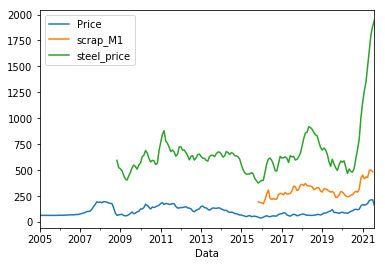

In [56]:
plt.figure(figsize = (16,7))
df_all[['Price','scrap_M1','steel_price']].plot()
plt.show()

### 3.2 Iron Ore Prices EDA

As it is possible to infer from the above chart, there is minor variation on the iron ore prices before 2005. So, only the most recent data starting on 2005 will be investigated.  
  
Historical prices series are typical time series data. The iron ore prices will be investigated using time series approach. 
It can present trend and seasonality.

When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase. When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags (https://otexts.com/fpp2/autocorrelation.html)

When data are both trended and seasonal, you see a combination of these effects. 

Let's take a look at:  
- Auto Correlation plot
- Lag plot

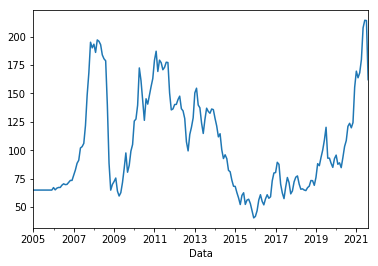

In [57]:
# Subset the original series to only most recent data (>2005)
df = df[df.index>='2005'].copy()
df['Price'].plot();

In [58]:
print("The iron ore prices over the period from {0} to {1} ranges from US${2} to US${3}."\
.format(df.index.min().year,df.index.max().year,df['Price'].min(), df['Price'].max()))
df['Price'].describe()

The iron ore prices over the period from 2005 to 2021 ranges from US$40.5 to US$214.43.


count    200.000000
mean     104.976116
std       43.516408
min       40.500000
25%       67.300000
50%       91.937000
75%      136.721250
max      214.430000
Name: Price, dtype: float64

There is a sharp decrease in prices around 2008-2009; this is due to financial crisis in 2008.

**Auto Correlation Plot - Comments:**  
We can see from the chart below that there is a positive correlation with the first ~40 lags that is significant for the about first 12 lags.  
The stronger correlations values (>0.5) are about 8 lags.  
It is interesting to see that after 50 lags the autocorrelation turns to be significant again, but negative. Perhaps this could be due to a cyclic movement - a business cycle. The most negative correlation can be observed at 60 lags. It is not possible to see a clear seasonality effect.

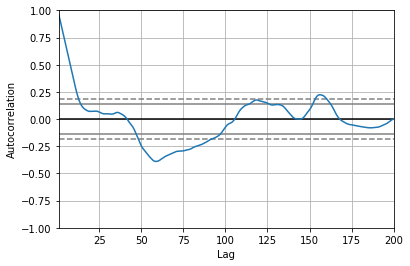

In [59]:
pd.plotting.autocorrelation_plot(df['Price']);

**Lag Plot - Comments:**  
A Lag plot is a scatter plot of a time series against a lag of itself. It is also used to check for autocorrelation. If there is any pattern existing in the series, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.  
As it can be seen in the chart below, there's a strong linear pattern between the iron ore price and its lag.

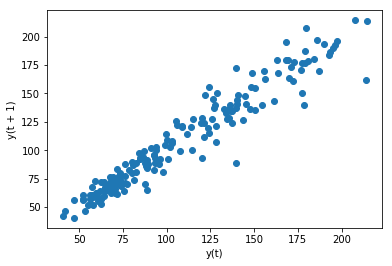

In [60]:
pd.plotting.lag_plot(df['Price']);

#### Testing for Stationarity  
"A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time."(https://otexts.com/fpp2/stationarity.html)

Several tests can be performed to infer whether a series is stationary or not. The null hypothesis is that the data are stationary, and the test look for evidence that the null hypothesis is false. Consequently, small p-values (e.g., less than 0.05) suggest that differencing is required. The AdFuller test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test area examples of stationarity tests.

In [21]:
### Testing For Stationarity
def adfuller_test(s):
    """
    Input:
    s: series to test for stationarity
    
    Description:
    Stationary data means data which has no trend with respect to the time
    Ho: It is non stationary
    H1: It is stationary
    """
    result= sm.tsa.stattools.adfuller(s)
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05: Reject the null hypothesis(Ho) for non stationary series.")
    else:
        print("Weak evidence against null hypothesis: it indicates that the series is non-stationary.")

adfuller_test(df['Price'])

ADF Test Statistic : -2.7863168879054623
p-value : 0.06025504181421079
Number of Lags Used : 1
Number of Observations Used : 198
Weak evidence against null hypothesis: it indicates that the series is non-stationary.


In [22]:
# Test for trend and seasonality
# KPSS Test
def kpss_test(series):
    """
    Input: series to test for stationarity
    
    Description: the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that the series is level or trend stationary.
    """
result = sm.tsa.stattools.kpss(df['Price'], regression='c')
print('\nKPSS Statistic for level: %f' % result[0])
print('p-value: %f' % result[1])
#for key, value in result[3].items():
#    print('Critical Values:')
#    print(f'   {key}, {value}')
result = sm.tsa.stattools.kpss(df['Price'], regression='ct')
print('\nKPSS Statistic for trend: %f' % result[0])
print('p-value: %f' % result[1])
#for key, value in result[3].items():
#    print('Critical Values:')
#    print(f'   {key}, {value}')


KPSS Statistic for level: 0.149973
p-value: 0.100000

KPSS Statistic for trend: 0.135966
p-value: 0.068581


C:\Users\Rejane\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Rejane\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


### 3.3 Exogenous Variables EDA

Ref: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html  
"The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero.
So the Null hypothesis is: the series in the second column, does not Granger cause the series in the first. If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful."

In [61]:
exogenous = df_all[['scrap_M1','steel_price','China_gdp_pc']]

In [62]:
# Test for causality - over a 6-month period
for s in exogenous:
    print(s)
    sm.tsa.stattools.grangercausalitytests(df_all[['Price', s]].dropna(), maxlag=6)
    print()

scrap_M1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6967  , p=0.4070  , df_denom=65, df_num=1
ssr based chi2 test:   chi2=0.7289  , p=0.3933  , df=1
likelihood ratio test: chi2=0.7250  , p=0.3945  , df=1
parameter F test:         F=0.6967  , p=0.4070  , df_denom=65, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5826  , p=0.5614  , df_denom=62, df_num=2
ssr based chi2 test:   chi2=1.2593  , p=0.5328  , df=2
likelihood ratio test: chi2=1.2476  , p=0.5359  , df=2
parameter F test:         F=0.5826  , p=0.5614  , df_denom=62, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1288  , p=0.9426  , df_denom=59, df_num=3
ssr based chi2 test:   chi2=0.4323  , p=0.9335  , df=3
likelihood ratio test: chi2=0.4309  , p=0.9338  , df=3
parameter F test:         F=0.1288  , p=0.9426  , df_denom=59, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0836  , p=0.987

**Comments from Granger Causality Tests Results (taking p-value 10% as significant:**  
- Scrap prices don't make Iron Ore prices to change.  
- Steel prices from past 2nd and 3rd months make Iron Ore prices to change.  
- China GDP Growth from 1st and 6th previous months make Iron Ore prices to change.

### Insights from EDA results:  
1) ACF Plot and Lag Plot show that past values are important to determine future values of iron ore prices. The stationarity tests (the AdFuller test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS)) also have shown that iron ore prices is a non-stationary series. So a simple linear regression model won't be a suitable model as this kind of model doesn't cover the autoregressive component. A time series approach like ARIMA should be more appropriate.  
2) Some exogenous variables were considered to be important variables as they can influence the iron ore prices from the demand perspective. A set of Granger Causality tests were carried out for the main exogenous variables, but for two of them it's shown to be relevant: past steel prices (lags 2 and 3) and China GDP Growth from previous months (lags 1 and 6).

**EDA Directions to Modeling Phase:**  
An ARIMAX Model should be evaluated to iron ore prices forecasting, as it is a non-stationary series and it has relevant exogenous variables which influences its values.

## 4. Modeling

### 4.0 Preparation for Modeling
Defining functions for Modeling

In [17]:
# Accuracy metrics
def forecast_accuracy(y_forecast, y_true):
    """
    This function summarizes the main evaluation metrics for the forecasting model
    
    Inputs: 
    y_forecast: series of predicted values from the model
    y_true: series of true values 
    
    Returns: a dictionary with evaluation metrics

    """
    mape = np.mean(np.abs(y_forecast - y_true)/np.abs(y_true))  # MAPE
    me = np.mean(y_forecast - y_true)             # ME
    mae = np.mean(np.abs(y_forecast - y_true))    # MAE
    mpe = np.mean((y_forecast - y_true)/y_true)   # MPE
    rmse = np.mean((y_forecast - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_forecast, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_forecast[:,None], y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_forecast[:,None], y_true[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = sm.tsa.stattools.acf(y_forecast)[1]    # ACF1 - for residues evaluation
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

### 4.1 POC Modeling
The results from EDA Phase suggest that the ARIMAX model would be an appropriate approach as it can deal with the non-stationarity of the series and the influence of exogenous variables.

In [ ]:
# Feature Engineering from EDA results

df_all['steel_lag2'] = df_all['steel_price'].shift(2)
df_all['steel_lag3'] = df_all['steel_price'].shift(3)

df_all['china_gdp_ch_lag1'] = df_all['China_gdp_pc'].shift(1)
df_all['china_gdp_ch_lag6'] = df_all['China_gdp_pc'].shift(6)

In [63]:
# Preparing dataset for modeling
df_model = df_all.dropna().copy()
exog_model = ['steel_lag2','steel_lag3','china_gdp_ch_lag1','china_gdp_ch_lag6']

In [65]:
# split in train and test datasets
TEST_SIZE = .1
train = df_model[:int(df_model.shape[0]*(1-TEST_SIZE))]
test = df_model[int(df_model.shape[0]*(1-TEST_SIZE)):]

In [66]:
# fit model
model = arima.model.ARIMA(train['Price'], 
                          exog=train[exog_model], 
                          order=(8,1,0), 
                          dates = train.index) 
arimax = model.fit()
# summary of fit model
print(arimax.summary())

C:\Users\Rejane\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Rejane\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Rejane\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                   59
Model:                 ARIMA(8, 1, 0)   Log Likelihood                -192.390
Date:                Sun, 10 Oct 2021   AIC                            410.779
Time:                        17:50:10   BIC                            437.565
Sample:                    11-30-2015   HQIC                           421.213
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
steel_lag2           -0.0148      0.030     -0.491      0.623      -0.074       0.044
steel_lag3           -0.0060      0.029     -0.206      0.837      -0.064       0.052
china_gdp_ch_lag1     3.

C:\Users\Rejane\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


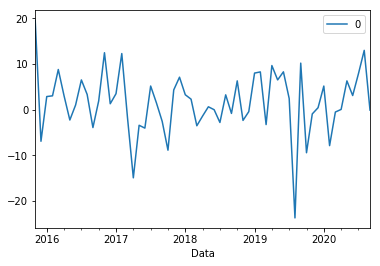

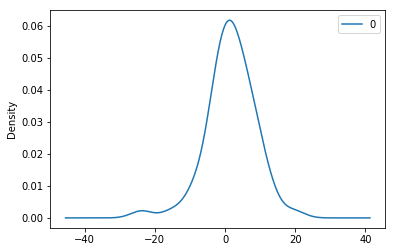

In [72]:
# residuals analysis
residuals = pd.DataFrame(arimax.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

In [68]:
# predictions
fc = arimax.predict(start=test.index.min(), end=test.index.max(), exog=[test[exog_model]])

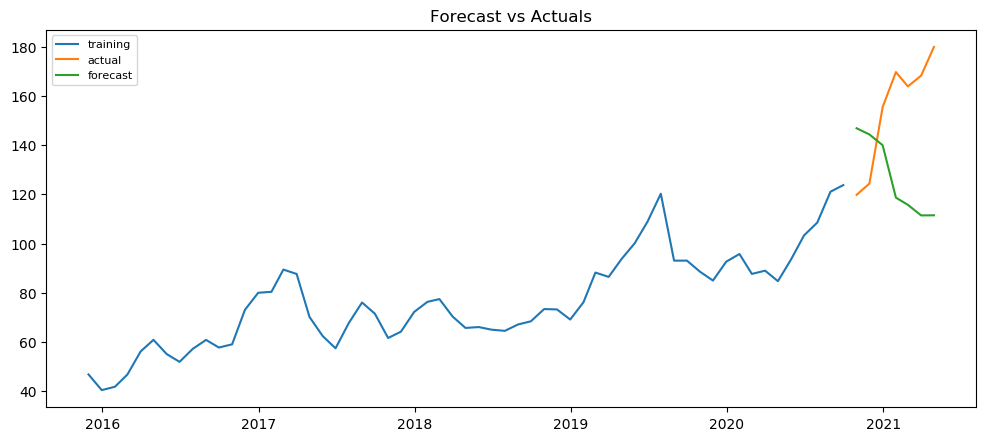

In [70]:
# predictions to series
fc_series = pd.Series(fc, index=test.index)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Price'], label='training')
plt.plot(test['Price'], label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Acknowlegments:
https://otexts.com/fpp2/  
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/  
https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/  
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/  
https://github.com/alkaline-ml/pmdarima
https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e
https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sci
https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8  
https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem
https://www.analyticsvidhya.com/blog/2021/06/random-forest-for-time-series-forecasting/
https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b  
https://machinelearningmastery.com/make-sample-forecasts-arima-python/